<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">  

<b> <font size='5'>  
ELEC PRICE PREDICTION CAPSTONE:</font>  

<font size='4'>ARIMA Models for Continuous Targets</font> </b>

<font size='3'>  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Manu Kalia Project Submission<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; DSI-7-SF<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 15-May-2019<br>
</font>

---


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Function-Definitions" data-toc-modified-id="Function-Definitions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Function Definitions</a></span></li><li><span><a href="#Load-Pickles:--Train/Test-Dataframes-&amp;--Full-Dataframe" data-toc-modified-id="Load-Pickles:--Train/Test-Dataframes-&amp;--Full-Dataframe-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load Pickles:  Train/Test Dataframes &amp;  Full Dataframe</a></span></li><li><span><a href="#Augmented-Dickey-Fuller-Test" data-toc-modified-id="Augmented-Dickey-Fuller-Test-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Augmented Dickey-Fuller Test</a></span></li><li><span><a href="#Choose-Values-for-p-and-q" data-toc-modified-id="Choose-Values-for-p-and-q-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Choose Values for <code>p</code> and <code>q</code></a></span></li><li><span><a href="#Gridsearch-to-find-lowest-MSE-params-for-p,-d,-q" data-toc-modified-id="Gridsearch-to-find-lowest-MSE-params-for-p,-d,-q-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Gridsearch to find lowest MSE params for <code>p</code>, <code>d</code>, <code>q</code></a></span></li><li><span><a href="#Instantiate-and-Fit-ARIMA-for-Day-Ahead-with-4,-0,-6-as-Params" data-toc-modified-id="Instantiate-and-Fit-ARIMA-for-Day-Ahead-with-4,-0,-6-as-Params-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Instantiate and Fit ARIMA for Day Ahead with 4, 0, 6 as Params</a></span></li><li><span><a href="#Instantiate-and-Fit-ARIMA-for-Hour-Ahead-with-6,-0,-6-as-Params" data-toc-modified-id="Instantiate-and-Fit-ARIMA-for-Hour-Ahead-with-6,-0,-6-as-Params-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Instantiate and Fit ARIMA for Hour Ahead with 6, 0, 6 as Params</a></span></li></ul></div>

---

## Imports

In [36]:
import pandas as pd
import numpy as np

import pickle
import wget, os
import time
import glob
import pytz

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
 
register_matplotlib_converters()
%matplotlib inline
sns.set_style('whitegrid')

In [58]:
# from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score

---

## Function Definitions

In [39]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [40]:
# From Matt Brems lecture

def MSE(true, predicted):
    squared_diff = np.square(true - predicted)
    return np.mean(squared_diff)

# Root Mean Square Error
def RMSE(true, predicted):
    squared_diff = np.square(true - predicted)    
    return np.sqrt(np.mean(squared_diff))

# R-squared, coefficient of determination
def R_squared(true, predicted):
    true      = np.array(true)
    predicted = np.array(predicted)
    sum_squared_diff = sum(np.square(true - predicted))
    variance  = sum(np.square(true - np.mean(true)))
    calc_r2   = 1 - (sum_squared_diff / variance)
    return calc_r2

---

## Load Pickles:  Train/Test Dataframes &  Full Dataframe

In [41]:
with open('../data/processed/train.pkl', 'rb') as f:
    train = pickle.load(f)
    
with open('../data/processed/test.pkl', 'rb') as f:
    test = pickle.load(f)
    
with open('../data/pre_processed_df.pkl', 'rb') as f:
    df = pickle.load(f)

---

## Augmented Dickey-Fuller Test

P-value for both target variables are **extremely** low (`1.4e-19` and `6.5e-28` for day-ahead and hour-ahead prices, respectively), so they both pass the the test for stationarity, assuming some low threshold for $\alpha$ such as 0.05 or 0.01  

Differencing is not required, so set `$d = 0$`.

In [8]:
interpret_dftest(adfuller(train['dam_price_per_mwh']))

Test Statistic   -1.086989e+01
p-value           1.377061e-19
dtype: float64

In [9]:
interpret_dftest(adfuller(train['hasp_price_per_mwh']))

Test Statistic   -1.516645e+01
p-value           6.481191e-28
dtype: float64

---

## Choose Values for `p` and `q`

 * Endogenous variable: **DA price** ... $p=1$ ... sharp cutoff in PACF bet. lag-1 & lag-2; ACF lag-1 > 0  
 * Endogenous variable: **DA price** ... $q=0$ ... ACF lag-1 is not negative  
 <br/>
 * Endogenous variable: **HA price** ... $p=1$ ... sharp cutoff in PACF bet. lag-1 & lag-2; ACF lag-1 > 0  
 * Endogenous variable: **HA price** ... $q=0$ ... ACF lag-1 is not negative  
 <br/>

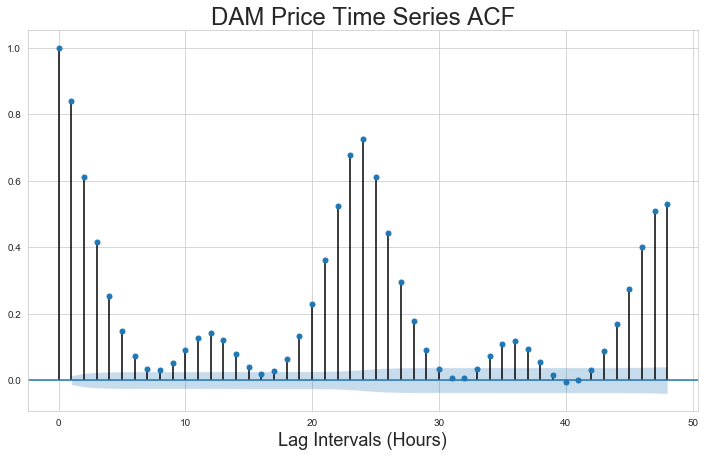

In [12]:
fig, ax = plt.subplots(figsize=(12,7))
plot_acf(train['dam_price_per_mwh'], lags=24*2, ax=ax)
plt.title('DAM Price Time Series ACF', fontsize=24)
plt.xlabel('Lag Intervals (Hours)', fontsize=18)
plt.savefig('../images/dam_acf.jpg')
plt.show();

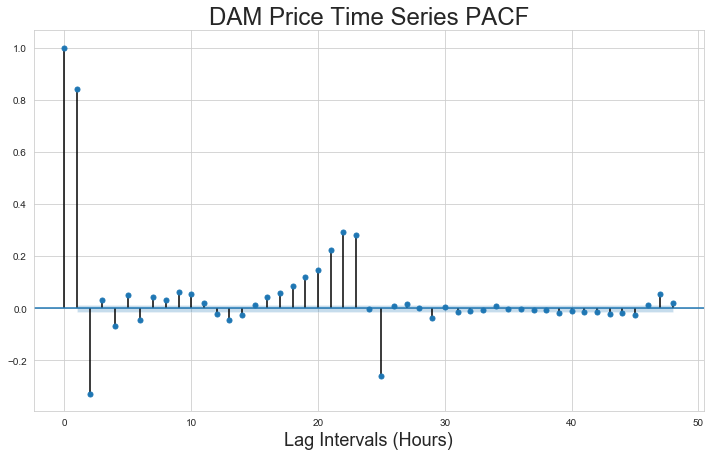

In [13]:
fig, ax = plt.subplots(figsize=(12,7))
plot_pacf(train['dam_price_per_mwh'], lags=24*2, ax=ax)
plt.title('DAM Price Time Series PACF', fontsize=24)
plt.xlabel('Lag Intervals (Hours)', fontsize=18)
plt.savefig('../images/dam_pacf.jpg')
plt.show();

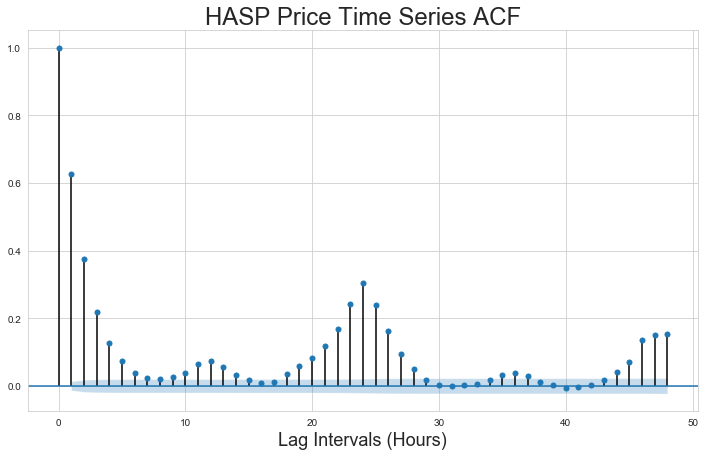

In [15]:
fig, ax = plt.subplots(figsize=(12,7))
plot_acf(train['hasp_price_per_mwh'], lags=24*2, ax=ax)
plt.title('HASP Price Time Series ACF', fontsize=24)
plt.xlabel('Lag Intervals (Hours)', fontsize=18)
plt.savefig('../images/hasp_acf.jpg')
plt.show();

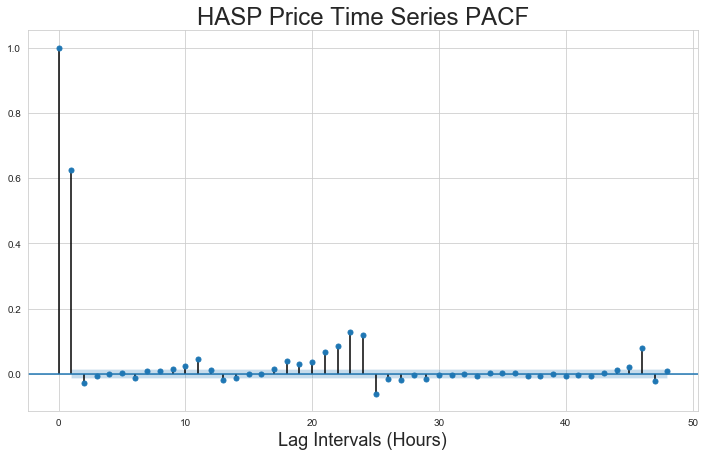

In [16]:
fig, ax = plt.subplots(figsize=(12,7))
plot_pacf(train['hasp_price_per_mwh'], lags=24*2, ax=ax)
plt.title('HASP Price Time Series PACF', fontsize=24)
plt.xlabel('Lag Intervals (Hours)', fontsize=18)
plt.savefig('../images/hasp_pacf.jpg')
plt.show();

---

## Gridsearch to find lowest MSE params for `p`, `d`, `q`

(for `DAM` and `HASP` prices as endogenous variables)



In [34]:
# Matt Brem's grid search loop

for p in range(7):
    for d in range(7):
        for q in range(7):
            try:
                dam_arima = ARIMA(endog = train['dam_price_per_mwh'].astype('float32'), # Y variable
                              order = (p, d, q)) # (p, d, q)
                dam_model = dam_arima.fit()
                dam_preds = dam_model.predict()
                print(f'MSE for (p={p}, d={d}, q={q}) ... {mean_squared_error(train["dam_price_per_mwh"], dam_preds)}')
            
            except:
                pass

/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=0, d=0, q=0) ... 426.36566006002545
MSE for (p=0, d=0, q=1) ... 180.3241706704521


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

MSE for (p=1, d=0, q=0) ... 124.97718666381336


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=1) ... 111.66488765092917


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=2) ... 111.55511096243268


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=3) ... 110.39468640392809


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=4) ... 110.38667558541545


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=5) ... 109.25572059509933


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=6) ... 108.29985883596329


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

MSE for (p=2, d=0, q=0) ... 111.56404229239372


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=1) ... 111.37721489371023


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=2) ... 111.03321972408797


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=3) ... 110.38066473314079


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=4) ... 108.18060959473196


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=5) ... 107.49626757974505


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=6) ... 106.31032348631769


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

MSE for (p=3, d=0, q=0) ... 111.46317265985816


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=1) ... 109.05347072531049


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=2) ... 110.35319377608806


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=3) ... 103.55945664227609


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=4) ... 104.4054354121607


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=5) ... 105.99956291923954


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=6) ... 102.77035503267885


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

MSE for (p=4, d=0, q=0) ... 110.92355529087577


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=1) ... 110.31973155695584


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=2) ... 110.28302082465274


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=3) ... 103.13846640781675


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=4) ... 103.03437551766501


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=5) ... 103.03288652474689


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=6) ... 101.24055096374197


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

MSE for (p=5, d=0, q=0) ... 110.62583239298174


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=1) ... 107.7200902589757


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=2) ... 107.4920985567981


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=3) ... 103.06192627273367


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=4) ... 103.03379421461386


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=5) ... 102.94990064129885


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=6) ... 102.59222162572325


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

MSE for (p=6, d=0, q=0) ... 110.39374903440836


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=1) ... 107.7165222291897


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=2) ... 107.62895871532776


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=3) ... 103.42329892593925


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=4) ... 103.73682179507146


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=5) ... 101.93392995186537


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=6) ... 101.9323907196177


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

In [41]:
# Matt Brem's grid search loop

for p in range(7):
    for d in range(7):
        for q in range(7):
            try:
                hasp_arima = ARIMA(endog = train['hasp_price_per_mwh'].astype('float32'), # Y variable
                              order = (p, d, q)) # (p, d, q)
                hasp_model = hasp_arima.fit()
                hasp_preds = hasp_model.predict()
                print(f'MSE for (p={p}, d={d}, q={q}) ... {mean_squared_error(train["hasp_price_per_mwh"], hasp_preds):.2f}')
            
            except:
                pass

/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=0, d=0, q=0) ... 1677.48
MSE for (p=0, d=0, q=1) ... 1159.42
MSE for (p=0, d=0, q=2) ... 1058.84


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=0, d=0, q=3) ... 1032.00


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=0, d=0, q=4) ... 1025.19


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=0, d=0, q=5) ... 1021.38


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=0, d=0, q=6) ... 1020.54


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

MSE for (p=1, d=0, q=0) ... 1021.46
MSE for (p=1, d=0, q=1) ... 1020.64


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=2) ... 1020.58


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=3) ... 1020.58


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=4) ... 1020.57


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=5) ... 1014.13


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=1, d=0, q=6) ... 1012.02


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

MSE for (p=2, d=0, q=0) ... 1020.62


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=1) ... 1020.58


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=2) ... 1020.58


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=3) ... 1012.49


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=4) ... 1012.35


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=5) ... 1012.31


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=2, d=0, q=6) ... 1011.87


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=0) ... 1020.58


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=1) ... 1020.58


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=2) ... 1010.15


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=3) ... 1010.14


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=4) ... 1012.32


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=5) ... 1012.30


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=3, d=0, q=6) ... 1013.27


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

MSE for (p=4, d=0, q=0) ... 1020.58


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=1) ... 1012.39


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=2) ... 1010.14


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=3) ... 1009.73


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=4) ... 1001.30


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=4, d=0, q=5) ... 1000.78


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

MSE for (p=4, d=0, q=6) ... 992.96


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

MSE for (p=5, d=0, q=0) ... 1020.57


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=1) ... 1012.20


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=2) ... 1012.22


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=3) ... 1009.70


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=4) ... 1000.71


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=5) ... 1000.68


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=5, d=0, q=6) ... 992.65


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=0) ... 1020.43


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=1) ... 1012.04


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=2) ... 1012.17


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=3) ... 1009.45


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=4) ... 1000.68


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=5) ... 999.52


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MSE for (p=6, d=0, q=6) ... 991.07


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has bee

---

## Instantiate and Fit ARIMA for Day Ahead with 4, 0, 6 as Params

In [42]:
p = 4
d = 0
q = 6

dam_arima406 = ARIMA(endog = train['dam_price_per_mwh'].astype('float32'),  # Y variable
                     order = (p, d, q))                                     # (p, d, q)

dam_arima406_model = dam_arima406.fit()

/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [43]:
dam_arima406_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:      dam_price_per_mwh   No. Observations:                21800
Model:                     ARMA(4, 6)   Log Likelihood              -81265.485
Method:                       css-mle   S.D. of innovations             10.062
Date:                Thu, 16 May 2019   AIC                         162554.970
Time:                        21:54:15   BIC                         162650.846
Sample:                             0   HQIC                        162586.207
                                                                              
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      32.6655      1.407     23.215      0.000      29.908      35.423
ar.L1.dam_price_per_mwh     3.3251      0.004    793.030      0.000       3.317       3.333
ar.L2.dam_price_per_mwh    -4.3561      0.011   -383.220      0.000      -4.378      -4.334
ar.L3.dam_price_per_mwh     2.6279      0.011    232.191      0.000       2.606       2.650
ar.L4.dam_price_per_mwh    -0.5973      0.004   -144.486      0.000      -0.605      -0.589
ma.L1.dam_price_per_mwh    -2.2645      0.008   -274.879      0.000      -2.281      -2.248
ma.L2.dam_price_per_mwh     1.5797      0.019     84.908      0.000       1.543       1.616
ma.L3.dam_price_per_mwh     0.0548      0.020      2.690      0.007       0.015       0.095
ma.L4.dam_price_per_mwh    -0.4263      0.020    -20.843      0.000      -0.466      -0.386
ma.L5.dam_price_per_mwh     0.1413      0.016      8.644      0.000       0.109       0.173
ma.L6.dam_price_per_mwh    -0.0770      0.007    -11.474      0.000      -0.090      -0.064
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8661           -0.5025j            1.0013           -0.0837
AR.2            0.8661           +0.5025j            1.0013            0.0837
AR.3            1.0036           -0.0000j            1.0036           -0.0000
AR.4            1.6639           -0.0000j            1.6639           -0.0000
MA.1            1.0194           -0.0000j            1.0194           -0.0000
MA.2            0.8758           -0.5066j            1.0118           -0.0835
MA.3            0.8758           +0.5066j            1.0118            0.0835
MA.4           -1.8060           -0.0000j            1.8060           -0.5000
MA.5            0.4352           -2.5893j            2.6257           -0.2235
MA.6            0.4352           +2.5893j            2.6257            0.2235
-----------------------------------------------------------------------------
"""

In [44]:
print(f'df:     {df.shape[0]}')
print(f'train:  {train.shape[0]}')
print(f'test:   {test.shape[0]}')
print(f'trn+tst:{train.shape[0] + test.shape[0]}')

df:     29067
train:  21800
test:   7267
trn+tst:29067


In [59]:
dam_arima406_train_preds = dam_arima406_model.predict(start= 0,
                                                      end  = train.shape[0]-1)
print(f'MSE  Train ARIMA({p},{d},{q}) ... \
{mean_squared_error(train["dam_price_per_mwh"], dam_arima406_train_preds):.2f}')
      
print(f'R-sq Train ARIMA({p},{d},{q}) ... \
{r2_score(train["dam_price_per_mwh"], dam_arima406_train_preds):.4f}')

MSE  Train ARIMA(4,0,6) ... 101.24
R-sq Train ARIMA(4,0,6) ... 0.7625


In [60]:
dam_arima406_test_preds = dam_arima406_model.predict(start = train.shape[0],
                                                     end   = df.shape[0]-1)
print(f'MSE  Test ARIMA({p},{d},{q}) ... \
{mean_squared_error(test["dam_price_per_mwh"], dam_arima406_test_preds):.2f}')
      
print(f'R-sq Test ARIMA({p},{d},{q}) ... \
{r2_score(test["dam_price_per_mwh"], dam_arima406_test_preds):.4f}')

MSE  Test ARIMA(4,0,6) ... 1692.87
R-sq Test ARIMA(4,0,6) ... -0.1732


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [67]:
dam_arima406_train_resid = train["dam_price_per_mwh"] - dam_arima406_train_preds
dam_arima406_test_resid = test["dam_price_per_mwh"] - dam_arima406_test_preds

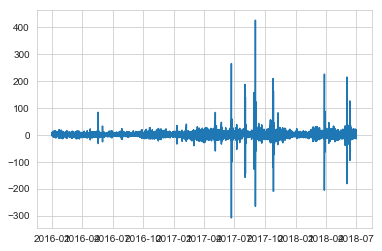

In [69]:
plt.plot(dam_arima406_train_resid);

In [47]:
with open('../fitted_models/dam_arima406_model.pkl', 'wb') as f:
    pickle.dump(dam_arima406_model, f)
    
with open('../data/predictions/dam_arima406_train_preds.pkl', 'wb') as f:
    pickle.dump(dam_arima406_train_preds, f)
    
with open('../data/predictions/dam_arima406_test_preds.pkl', 'wb') as f:
    pickle.dump(dam_arima406_test_preds, f)

---

## Instantiate and Fit ARIMA for Hour Ahead with 6, 0, 6 as Params

In [48]:
x = 6
y = 0
z = 6

hasp_arima606 = ARIMA(endog = train['hasp_price_per_mwh'].astype('float32'),  # Y variable
                     order = (x, y, z))                                     # (p, d, q)

hasp_arima606_model = hasp_arima606.fit()

/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [49]:
hasp_arima606_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:     hasp_price_per_mwh   No. Observations:                21800
Model:                     ARMA(6, 6)   Log Likelihood             -106130.765
Method:                       css-mle   S.D. of innovations             31.481
Date:                Thu, 16 May 2019   AIC                         212289.531
Time:                        21:55:46   BIC                         212401.386
Sample:                             0   HQIC                        212325.974
                                                                              
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       32.6162      2.300     14.180      0.000      28.108      37.125
ar.L1.hasp_price_per_mwh     2.5075      0.013    192.254      0.000       2.482       2.533
ar.L2.hasp_price_per_mwh    -2.6539      0.035    -76.535      0.000      -2.722      -2.586
ar.L3.hasp_price_per_mwh     2.3679      0.049     48.740      0.000       2.273       2.463
ar.L4.hasp_price_per_mwh    -2.6610      0.047    -57.210      0.000      -2.752      -2.570
ar.L5.hasp_price_per_mwh     1.9656      0.029     67.646      0.000       1.909       2.023
ar.L6.hasp_price_per_mwh    -0.5267      0.010    -52.133      0.000      -0.546      -0.507
ma.L1.hasp_price_per_mwh    -1.8877      0.015   -128.582      0.000      -1.917      -1.859
ma.L2.hasp_price_per_mwh     1.4657      0.032     45.642      0.000       1.403       1.529
ma.L3.hasp_price_per_mwh    -1.4414      0.035    -41.470      0.000      -1.510      -1.373
ma.L4.hasp_price_per_mwh     1.7709      0.029     60.672      0.000       1.714       1.828
ma.L5.hasp_price_per_mwh    -0.8509      0.023    -37.279      0.000      -0.896      -0.806
ma.L6.hasp_price_per_mwh    -0.0508      0.011     -4.644      0.000      -0.072      -0.029
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4042           -0.9398j            1.0231           -0.3146
AR.2           -0.4042           +0.9398j            1.0231            0.3146
AR.3            0.8659           -0.5023j            1.0011           -0.0837
AR.4            0.8659           +0.5023j            1.0011            0.0837
AR.5            1.0016           -0.0000j            1.0016           -0.0000
AR.6            1.8071           -0.0000j            1.8071           -0.0000
MA.1           -0.3989           -0.9349j            1.0164           -0.3142
MA.2           -0.3989           +0.9349j            1.0164            0.3142
MA.3            0.8702           -0.5041j            1.0056           -0.0836
MA.4            0.8702           +0.5041j            1.0056            0.0836
MA.5            1.0076           -0.0000j            1.0076           -0.0000
MA.6          -18.7098           -0.0000j           18.7098           -0.5000
-----------------------------------------------------------------------------
"""

In [50]:
hasp_arima606_train_preds = hasp_arima606_model.predict(start= 0,
                                                      end  = train.shape[0]-1)
print(f'MSE  Train ARIMA({x},{y},{z}) ... \
{MSE(train["hasp_price_per_mwh"], hasp_arima606_train_preds):.2f}')
      
print(f'R-sq Train ARIMA({x},{y},{z}) ... \
{R_squared(train["hasp_price_per_mwh"], hasp_arima606_train_preds):.4f}')

MSE  Train ARIMA(6,0,6) ... 991.07
R-sq Train ARIMA(6,0,6) ... 0.4092


In [51]:
hasp_arima606_test_preds = hasp_arima606_model.predict(start = train.shape[0],
                                                    end   = df.shape[0]-1)
print(f'MSE  Test ARIMA({x},{y},{z}) ... \
{MSE(test["hasp_price_per_mwh"], hasp_arima606_test_preds):.2f}')
      
print(f'R-sq Test ARIMA({x},{y},{z}) ... \
{R_squared(test["hasp_price_per_mwh"], hasp_arima606_test_preds):.4f}')

MSE  Test ARIMA(6,0,6) ... nan
R-sq Test ARIMA(6,0,6) ... -0.1333


/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [52]:
with open('../fitted_models/hasp_arima606_model.pkl', 'wb') as f:
    pickle.dump(hasp_arima606_model, f)
    
with open('../data/predictions/hasp_arima606_train_preds.pkl', 'wb') as f:
    pickle.dump(hasp_arima606_train_preds, f)
    
with open('../data/predictions/hasp_arima606_test_preds.pkl', 'wb') as f:
    pickle.dump(hasp_arima606_test_preds, f)